# How does a one-off oil price rise cause an inflation spiral?

Plan: 
Title
Video
Explanation / Further Reading
Interactive bits
Questions

### --hidden--

In [1]:
import ipywidgets as widgets

In [2]:
### CE SIM CODE

import pandas as pd
import numpy as np


##### No Policy means that nominal interest rate is always 0
##### real interest rate then = -inflation, reflecting how savings are losing money in inflation
##### this should return an inflation spiral
##### we're gonna start with inflation = 0 (piT = 0 in the code, ik it's a bit confusing)
##### also, no CBbeta because central bank doesn't exist, so inflation = output gap for all periods

###Helper Methods

def FindOptimumY(expectedinflation, ye=100, piT=2, alpha=1, beta=1):
    ###optimum y found using intersect of next period's PC, MR
    #this is central bank finding its target in response to this period's distance from equilibrium
    y = (((alpha * beta) * (piT - expectedinflation)) / (1 + ((alpha ** 2) * (beta)))) + ye
    return y

def FindResponse(optimumY, A, a=0.75):
    ###optimum r using optimum y
    #this is cb finding real interest rate response to target to get to optimal y, using its IS curve
    r = (A - optimumY) / a 
    return r

def InflationfromY(y, ye=100, piT = 0):
    ###find inflation in economy from bargaining gap 
    pi = (y - ye) + piT
    return pi

###Simulator

class CENoPolicysim():
    def __init__(self, periods=25, ye=100, alpha=1, a=2, 
                credibility=0):
        
        self.periods=periods
        self.ye = ye
        self.rstar = 0 ### NO POLICY
        self.alpha = alpha
        self.a = a
        self.piT = 0 ### NO INFLATION YET
        self.credibility = credibility
        self.anticredibility = 1 - credibility

        self.A = ye + (a * self.rstar)
        self.cols = ['Periods', 'Output Gap', 'GDP', 'Inflation', 'Expected Inflation', 'Lending real i.r.', 'Lending nom i.r.', 
                    'A']
        
    def DemandShock(self, size, temporary=True):
        self.size = size
        self.multiplier = (0.01 * self.size) + 1
        self.newA = self.A * self.multiplier ## not sure about this
        df = pd.DataFrame(columns=self.cols)

        period = 1
        while period < 5:
            periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            periodseries['Output Gap'] = 0.0
            periodseries['GDP'] = self.ye
            periodseries['Inflation'] = self.piT
            periodseries['Expected Inflation'] = self.piT ####up to p5, piE = piT
            periodseries['Lending real i.r.'] = self.rstar
            periodseries['Lending nom i.r.'] = self.rstar + self.piT
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        
        while period < 6: #period 5 only
            #periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            #temporary demand shock
            periodseries['GDP'] = self.ye * self.multiplier
            periodseries['Output Gap'] = self.size
            inflation = self.piT + self.size
            periodseries['Inflation'] = inflation
            periodseries['Expected Inflation'] = self.piT ###In period 5, piE = pi(t-1) = piT (for all credibility)
            #cb response, finds PC where inflation = equilibrium output (this is next period's PC)
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #it uses next period's PC, so the expected inflation it uses is this period's inflation for adaptive
            #this will be useless for non-adaptive expectations - needs rewrite
            # cbresponsey = FindOptimumY(expectedinflation=inflation, piT=self.piT, alpha=self.alpha)
            # cbresponser = FindResponse(cbresponsey, A=self.A if temporary else self.newA, a=self.a)
            cbresponser = (-inflation)
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['Lending nom i.r.'] = 0
            periodseries['A'] = self.newA

            df.loc[period] = periodseries
            period += 1

        while period <= self.periods: #all post shock periods
            periodseries['Periods'] = period
            if temporary:
                periodseries['A'] = self.A
            else:
                periodseries['A'] = self.newA
            #beginning of recovery
            output = periodseries['A'] - (self.a * cbresponser)
            periodseries['GDP'] = output
            periodseries['Output Gap'] = output - self.ye
            periodseries['Expected Inflation'] = (self.credibility * self.piT) + (self.anticredibility * inflation)
            inflation = InflationfromY(output, piT=self.piT)
            periodseries['Inflation'] = inflation
            #cb response: finds PC where expected inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #gets optimal bargaining gap with r found with RX curve
            #again, expected inflation used for next period is this period's inflation for adaptive or anchored at piT
            # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
            # cbresponser = FindResponse(cbresponsey, A=self.A if temporary else self.newA, a=self.a)
            cbresponser = (-inflation)
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['Lending nom i.r.'] = 0
            #newq = FindQ(cbresponser)

            df.loc[period] = periodseries
            period += 1

        return df.round(4)

    def SupplyShock(self, size, temporary=True):
        self.size = size
        self.multiplier = (0.01 * self.size) + 1
        self.newye = self.ye * self.multiplier

        df = pd.DataFrame(columns=self.cols)

        period = 1
        while period < 5:
            periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            periodseries['Output Gap'] = 0.0
            periodseries['GDP'] = self.ye
            periodseries['Inflation'] = self.piT
            periodseries['Expected Inflation'] = self.piT ####up to p5, piE = piT
            periodseries['Lending real i.r.'] = self.rstar
            periodseries['Lending nom i.r.'] = self.rstar + self.piT
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        
        while period < 6:
            #periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            #permanent supply shock changes ye, not y
            periodseries['GDP'] = self.ye
            outputgap = ((self.ye - self.newye) / self.ye) * 100
            periodseries['Output Gap'] = outputgap
            periodseries['Expected Inflation'] = self.piT 
            inflation = self.piT + outputgap
            periodseries['Inflation'] = inflation
            #cb response, finds PC where inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #piE = df.loc[period - 1]['Inflation']
            # if temporary:
            #     # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
            #     # cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            # else:
                # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), ye=self.newye, piT=self.piT, alpha=self.alpha)
                # cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            cbresponser = (-inflation)
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['Lending nom i.r.'] = 0
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1

        while period <= self.periods:
            periodseries['Periods'] = period
            #beginning of recovery
            output = self.A - (self.a * cbresponser)
            periodseries['GDP'] = output
            periodseries['Output Gap'] = output - (self.ye if temporary else self.newye)
            periodseries['Expected Inflation'] = (self.credibility * self.piT) + (self.anticredibility * inflation)
            if temporary:
                inflation = InflationfromY(output, piT=self.piT)
            else:
                inflation = InflationfromY(output, ye=self.newye, piT=self.piT)
            periodseries['Inflation'] = inflation
            #cb response, finds PC where expected inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #piE = df.loc[period - 1]['Inflation']
            # if temporary:
            #     # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
            #     # cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            # else:
                # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), ye=self.newye, piT=self.piT, alpha=self.alpha)
                # cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            cbresponser = (-inflation)
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['Lending nom i.r.'] = 0
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        return df.round(4)

In [3]:
sim = CENoPolicysim(a=1.5)
spiraldf = sim.DemandShock(3)

In [4]:
spiraldf

,Periods,Output Gap,GDP,Inflation,Expected Inflation,Lending real i.r.,Lending nom i.r.,A
1,1.0,0.0000,100.0000,0.0000,0.0000,0.0000,0.0,100.0
2,2.0,0.0000,100.0000,0.0000,0.0000,0.0000,0.0,100.0
3,3.0,0.0000,100.0000,0.0000,0.0000,0.0000,0.0,100.0
4,4.0,0.0000,100.0000,0.0000,0.0000,0.0000,0.0,100.0
5,5.0,3.0000,103.0000,3.0000,0.0000,-3.0000,0.0,103.0
6,6.0,4.5000,104.5000,4.5000,3.0000,-4.5000,0.0,100.0
7,7.0,6.7500,106.7500,6.7500,4.5000,-6.7500,0.0,100.0
8,8.0,10.1250,110.1250,10.1250,6.7500,-10.1250,0.0,100.0
9,9.0,15.1875,115.1875,15.1875,10.1250,-15.1875,0.0,100.0
10,10.0,22.7812,122.7812,22.7812,15.1875,-22.7812,0.0,100.0


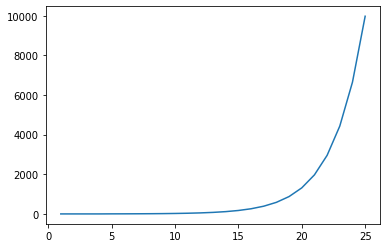

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(spiraldf['Periods'], spiraldf['Inflation'])

# Plotting an inflation spiral with interactive ipywidget

this is a 3% demand shock with no monetary policy at all

In [77]:
def plotbyperiod(period):
    fig, ax = plt.subplots(figsize=(16, 9))

    ax.set_xlim(1, 25)
    # ax.set_ylim(0, max(spiraldf['Inflation']))
    ax.set_xlabel('Periods')
    ax.set_ylabel('Inflation %')
    ax.set_title(r'What happens with no monetary policy in a temporary 3% demand shock?')

    ax.plot(spiraldf['Periods'][:period], spiraldf['Inflation'][:period], linewidth=4)
    plt.show()

widgets.interactive(plotbyperiod, period=widgets.IntSlider(value=5, min=1, max=25, layout=widgets.Layout(width='60vw')))

interactive(children=(IntSlider(value=5, description='period', layout=Layout(width='60vw'), max=25, min=1), Ou…

### --hidden--

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
#import time


##### No Policy means that nominal interest rate is always 0
##### real interest rate then = -inflation, reflecting how savings are losing money in inflation
##### this should return an inflation spiral
##### we're gonna start with inflation = 0 (piT = 0 in the code, ik it's a bit confusing)
##### also, no CBbeta because central bank doesn't exist, so inflation = output gap for all periods

###Helper Methods

# def FindOptimumY(expectedinflation, ye=100, piT=2, alpha=1, beta=1):
#     ###optimum y found using intersect of next period's PC, MR
#     #this is central bank finding its target in response to this period's distance from equilibrium
#     y = (((alpha * beta) * (piT - expectedinflation)) / (1 + ((alpha ** 2) * (beta)))) + ye
#     return y

# def FindResponse(optimumY, A, a=0.75):
#     ###optimum r using optimum y
#     #this is cb finding real interest rate response to target to get to optimal y, using its IS curve
#     r = (A - optimumY) / a 
#     return r

def InflationfromY(y, ye=100, piE = 0):
    ###find inflation in economy from bargaining gap 
    pi = (y - ye) + piE
    return pi


###Simulator

class CEInteractivePolicysim():
    def __init__(self, periods=25, ye=100, alpha=1, a=2, 
                credibility=0):
        
        self.periods=periods
        self.ye = ye
        self.rstar = 2 ### INITIAL POLICY
        self.alpha = alpha
        self.a = a
        self.piT = 0 ### NO INFLATION YET
        self.credibility = credibility
        self.anticredibility = 1 - credibility

        self.A = ye + (a * self.rstar)
        self.cols = ['Periods', 'Output Gap', 'GDP', 'Inflation', 'Expected Inflation', 'Lending real i.r.', 'Lending nom i.r.', 
                    'A']

    def PlotStuff(self, period, data):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(16, 16))

        ax1.set_xlim(1, self.periods)
        #ax1.set_ylim(0, data.loc[data['Periods'] == period]['Inflation'] + 10)
        ax1.set_ylabel('Inflation %')
        ax2.set_ylabel('GDP')
        ax3.set_ylabel('Real Interest Rate')
        ax4.set_ylabel('Nominal Interest Rate')

        ax1.set_ylim(min(data['Inflation']), max(data['Inflation']) + 2)
        ax2.set_ylim(min(data['GDP']) - 2 , max(data['GDP']) + 2)
        ax3.set_ylim(0, max(data['Lending real i.r.'][:-1]) + 2)
        ax4.set_ylim(0, max(data['Lending nom i.r.'][:-1]) + 2)

        ax1.plot(data['Periods'][:period], data['Inflation'][:period], linewidth=4)
        ax2.plot(data['Periods'][:period], data['GDP'][:period], linewidth=4)
        ax3.plot(data['Periods'][:period-1], data['Lending real i.r.'][:period-1], linewidth=4)
        ax4.plot(data['Periods'][:period-1], data['Lending nom i.r.'][:period-1], linewidth=4)
        return fig #### include other IRFs
        
    def DemandShock(self, size, temporary=True):

        self.size = size
        self.multiplier = (0.01 * self.size) + 1
        self.newA = self.A * self.multiplier ## not sure about this
        df = pd.DataFrame(columns=self.cols)

        period = 1
        while period < 5:
            periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            periodseries['Output Gap'] = 0.0
            periodseries['GDP'] = self.ye
            periodseries['Inflation'] = self.piT
            periodseries['Expected Inflation'] = self.piT ####up to p5, piE = piT
            periodseries['Lending real i.r.'] = self.rstar
            periodseries['Lending nom i.r.'] = self.rstar + self.piT
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        
        while period < 6: #period 5 only
            #periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            #temporary demand shock
            periodseries['GDP'] = self.ye * self.multiplier
            periodseries['Output Gap'] = self.size
            inflation = self.piT + self.size
            periodseries['Inflation'] = inflation
            periodseries['Expected Inflation'] = self.piT ###In period 5, piE = pi(t-1) = piT (for all credibility)
            #cb response, finds PC where inflation = equilibrium output (this is next period's PC)
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #it uses next period's PC, so the expected inflation it uses is this period's inflation for adaptive
            #this will be useless for non-adaptive expectations - needs rewrite
            # cbresponsey = FindOptimumY(expectedinflation=inflation, piT=self.piT, alpha=self.alpha)
            # cbresponser = FindResponse(cbresponsey, A=self.A if temporary else self.newA, a=self.a)
            periodseries['A'] = self.newA
            periodseries['Lending real i.r.'] = '? - inflation'
            periodseries['Lending nom i.r.'] = '?' 
            df.loc[period] = periodseries

            IPython.display.clear_output()
            fig = self.PlotStuff(period, data= df)
            plt.show()
            
            periodseries['Lending nom i.r.'] = float(input("There's been a shock! Choose a nominal rate to implement for next period to get curtail inflation!  "))

            # choice = widgets.FloatText(2)
            # button = widgets.Button(description='Submit')
            # output = widgets.Output()
            # display(choice, button, output)


            # def on_submit(b, period=period):
            #     with output:
            #         periodseries['Lending nom i.r.'] = choice.value
            #         cbresponser = choice.value - inflation
            #         periodseries['Lending real i.r.'] = cbresponser
        

            #         df.loc[period] = periodseries
            #         print('Period: ', period)
            #         print('Nom rate chosen: ', choice.value)
                    
            # button.on_click(on_submit)

            # period+=1


            cbresponser = periodseries['Lending nom i.r.'] - inflation
            periodseries['Lending real i.r.'] = cbresponser

            df.loc[period] = periodseries
            period += 1

        while period <= self.periods: #all post shock periods
            periodseries['Periods'] = period
            if temporary:
                periodseries['A'] = self.A
            else:
                periodseries['A'] = self.newA
            #beginning of recovery
            output = periodseries['A'] - (self.a * cbresponser)
            periodseries['GDP'] = output
            periodseries['Output Gap'] = output - self.ye
            piE = (self.credibility * self.piT) + (self.anticredibility * inflation)
            periodseries['Expected Inflation'] = piE
            inflation = InflationfromY(output, piE=piE)
            periodseries['Inflation'] = inflation
            #cb response: finds PC where expected inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #gets optimal bargaining gap with r found with RX curve
            #again, expected inflation used for next period is this period's inflation for adaptive or anchored at piT
            # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
            # cbresponser = FindResponse(cbresponsey, A=self.A if temporary else self.newA, a=self.a)
            periodseries['Lending real i.r.'] = '? - inflation'
            periodseries['Lending nom i.r.'] = '?' 
            df.loc[period] = periodseries
            IPython.display.clear_output()

            fig = self.PlotStuff(period, data= df)
            plt.show()

            # choice = widgets.FloatText(2)
            # button = widgets.Button(description='Submit')
            # output = widgets.Output()
            # display(choice, button, output)


            # def on_submit(b, period=period):
            #     with output:
            #         periodseries['Lending nom i.r.'] = choice.value
            #         cbresponser = choice.value - inflation
            #         periodseries['Lending real i.r.'] = cbresponser
        

            #         df.loc[period] = periodseries
            #         print('Period: ', period)
            #         print('Nom rate chosen: ', choice.value)
                    
            # button.on_click(on_submit)

            # period+=1

            periodseries['Lending nom i.r.'] = float(input('Choose a nominal rate for next period to guide recovery'))

            # # time.sleep(1)

            cbresponser = periodseries['Lending nom i.r.'] - inflation
            periodseries['Lending real i.r.'] = cbresponser
            #newq = FindQ(cbresponser)

            df.loc[period] = periodseries
            period += 1

        return df.round(4)

    def SupplyShock(self, size, temporary=True):
        self.size = size
        self.multiplier = (0.01 * self.size) + 1
        self.newye = self.ye * self.multiplier

        df = pd.DataFrame(columns=self.cols)

        period = 1
        while period < 5:
            periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            periodseries['Output Gap'] = 0.0
            periodseries['GDP'] = self.ye
            periodseries['Inflation'] = self.piT
            periodseries['Expected Inflation'] = self.piT ####up to p5, piE = piT
            periodseries['Lending real i.r.'] = self.rstar
            periodseries['Lending nom i.r.'] = self.rstar + self.piT
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        
        while period < 6:
            #periodseries = pd.Series(dtype=np.float64)
            periodseries['Periods'] = period
            #permanent supply shock changes ye, not y
            periodseries['GDP'] = self.ye
            outputgap = ((self.ye - self.newye) / self.ye) * 100
            periodseries['Output Gap'] = outputgap
            periodseries['Expected Inflation'] = self.piT 
            inflation = self.piT + outputgap
            periodseries['Inflation'] = inflation
            #cb response, finds PC where inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #piE = df.loc[period - 1]['Inflation']
            # if temporary:
            #     # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
            #     # cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            # else:
                # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), ye=self.newye, piT=self.piT, alpha=self.alpha)
                # cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            periodseries['Lending real i.r.'] = '? - inflation'
            periodseries['Lending nom i.r.'] = '?' 
            df.loc[period] = periodseries
            IPython.display.clear_output()
            
            fig = self.PlotStuff(period, data= df)
            plt.show()
            periodseries['Lending nom i.r.'] = float(input('Choose a nominal rate for next period to guide recovery'))

            # time.sleep(1)
            cbresponser = periodseries['Lending nom i.r.'] - inflation
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1

        while period <= self.periods:
            periodseries['Periods'] = period
            #beginning of recovery
            output = self.A - (self.a * cbresponser)
            periodseries['GDP'] = output
            periodseries['Output Gap'] = output - (self.ye if temporary else self.newye)
            periodseries['Expected Inflation'] = (self.credibility * self.piT) + (self.anticredibility * inflation)
            if temporary:
                inflation = InflationfromY(output, piT=self.piT)
            else:
                inflation = InflationfromY(output, ye=self.newye, piT=self.piT)
            periodseries['Inflation'] = inflation
            #cb response, finds PC where expected inflation = equilibrium output
            #then find that pc intersect with MR and that output is optimal bargaining gap
            #piE = df.loc[period - 1]['Inflation']
            # if temporary:
            #     # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), piT=self.piT, alpha=self.alpha)
            #     # cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            # else:
                # cbresponsey = FindOptimumY(expectedinflation=(self.credibility * self.piT) + (self.anticredibility * inflation), ye=self.newye, piT=self.piT, alpha=self.alpha)
                # cbresponser = FindResponse(cbresponsey, A=self.A, a=self.a)
            periodseries['Lending real i.r.'] = '? - inflation'
            periodseries['Lending nom i.r.'] = '?' 
            df.loc[period] = periodseries
            IPython.display.clear_output()
            
            fig = self.PlotStuff(period, data= df)
            plt.show()
            periodseries['Lending nom i.r.'] = float(input('Choose a nominal rate for next period to guide recovery'))

            # time.sleep(1)
            cbresponser = periodseries['Lending nom i.r.'] - inflation
            periodseries['Lending real i.r.'] = cbresponser
            periodseries['A'] = self.A

            df.loc[period] = periodseries
            period += 1
        return df.round(4)

# CRUDE VERSION OF 'CHOOSE YOUR OWN MONETARY POLICY'

This aims to allow you to use your own monetary policy in an attempt to get the economy back to equilibrium from 3% demand shock. 

It would be way more accessible with IPywidgets but it literally doesn't work. This is because IPywidgets are designed to be used for executed code already, instead of being used in the middle of an execution. It's impossible to make the code wait for an input before continuing, unless you do it the way I've done it here, using input function from vanilla python.

## How to Play

1. Run the code cell
2. You will be first presented with the state of the economy in period 5. Answer the input with a float representing your choice of nominal rate for the next period
3. Once you submit, you'll receive the state of the economy in period 6, having used your nominal rate. Choose another rate to advance to period 7
4. This continues for 15 periods, but you can interrupt execution whenever you want.
5. Obviously aim is to get back to equilibrium

In [ ]:
sim = CEInteractivePolicysim(periods=15)
df = sim.DemandShock(3)

output in one cell, with initial IRFs

widgets in seperate cell, with function that runs entire sim again with saved list of previous rates

idea is with button, run the sim with widget value as latest rate, clear old output and replace it with new output


output.clear_output(True) - wait for new display stuff


